In [1]:
!apt-get install build-essential swig
!curl https://raw.githubusercontent.com/automl/auto-sklearn/master/requirements.txt | xargs -n 1 -L 1 pip install
!pip install auto-sklearn

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
Suggested packages:
  swig-doc swig-examples swig3.0-examples swig3.0-doc
The following NEW packages will be installed:
  swig swig3.0
0 upgraded, 2 newly installed, 0 to remove and 20 not upgraded.
Need to get 1,100 kB of archives.
After this operation, 5,822 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig3.0 amd64 3.0.12-1 [1,094 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 swig amd64 3.0.12-1 [6,460 B]
Fetched 1,100 kB in 2s (636 kB/s)
Selecting previously unselected package swig3.0.
(Reading database ... 124016 files and directories currently installed.)
Preparing to unpack .../swig3.0_3.0.12-1_amd64.deb ...
Unpackin

In [1]:
import pandas as pd
import numpy as np
import os 
import sys
import glob
import json

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dropout, Dense
from xgboost import XGBRegressor
from autosklearn.regression import AutoSklearnRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
import os
os.chdir('/content/gdrive/My Drive/Colab Notebooks/furuno/weather_forecast')
sys.path.append("/content/gdrive/My Drive/Colab Notebooks/furuno/weather_forecast")
!pwd

/content/gdrive/My Drive/Colab Notebooks/furuno/weather_forecast


In [7]:
rain_data = pd.read_parquet('./data/radiometer.parquet')
full_rain_data = pd.read_parquet('./data/consolidate_10_minute.parquet')

In [8]:
from furuno_weather import Rain_Detection

In [9]:
time_field = 'date_time'
features = ['PWV_mm', 'Temperature_deg', 'RelativeHumidity', 'AtmosphericPressure_hPa']
measure = 'Rain_mV'
time_break = '2021-10-01'
target_sampling = '1H'
lags = [1,2,3]

rain_detector = Rain_Detection(rain_data, time_field, features, measure, target_sampling, lags)

In [10]:
modified_rain_data = rain_detector.preprocess()

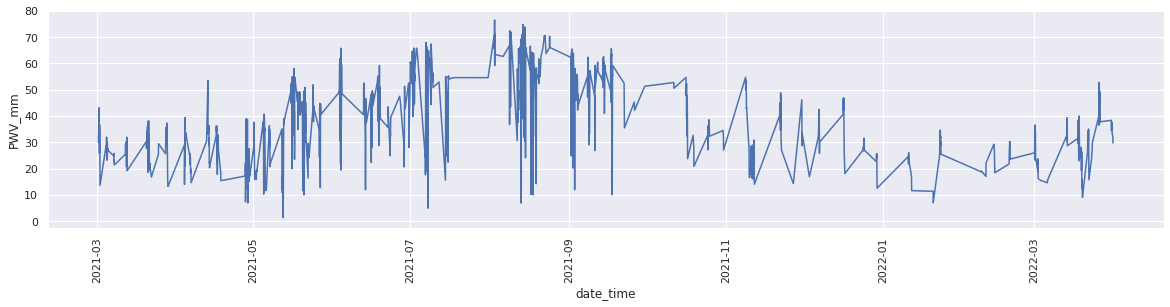

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

maybe_heavy_rain = modified_rain_data[modified_rain_data.rain_label > 30.0]
sns.set(rc={'figure.figsize':(20,4)})
sns.lineplot(x = maybe_heavy_rain.index, y = "PWV_mm", data = maybe_heavy_rain)
plt.xticks(rotation = 90)
plt.show()

In [11]:
train_data, test_data, models = rain_detector.train(modified_rain_data, time_break)

In [29]:
X_test, metrics = rain_detector.evaluate(test_data, models)
metrics

{'evaluation_metrics_model_1': {'MSE': 102.89170219531009,
  'MAPE': 1.3736990956035204e+16,
  'MAE': 4.482820421900338,
  'accuracy': 0.964441385638908},
 'evaluation_metrics_model_2': {'MSE': 124.21052314557285,
  'MAPE': 1.302198070404449e+16,
  'MAE': 4.587868070752766,
  'accuracy': 0.9561826106905253},
 'evaluation_metrics_model_3': {'MSE': 151.53072074807443,
  'MAPE': 1.4934943264424156e+16,
  'MAE': 5.287451871217355,
  'accuracy': 0.9479238357421427}}

In [30]:
models

{'model_lag_1': AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      n_jobs=8, per_run_time_limit=60,
                      time_left_for_this_task=360),
 'model_lag_2': AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      n_jobs=8, per_run_time_limit=60,
                      time_left_for_this_task=360),
 'model_lag_3': AutoSklearnRegressor(ensemble_class=<class 'autosklearn.ensembles.ensemble_selection.EnsembleSelection'>,
                      n_jobs=8, per_run_time_limit=60,
                      time_left_for_this_task=360)}

In [31]:
X_test.head()

,PWV_mm,Temperature_deg,RelativeHumidity,AtmosphericPressure_hPa
date_time,,,,
2021-10-01 00:00:00,37.423333,26.833333,60.983333,997.906667
2021-10-01 01:00:00,36.881667,27.153333,60.085000,997.813333
2021-10-01 02:00:00,31.496667,27.543333,57.438333,997.513333
2021-10-01 03:00:00,30.411667,27.956667,53.136667,997.571667
2021-10-01 04:00:00,27.130000,27.801667,53.501667,997.630000


In [27]:
target_lag = 2
x_test = pd.DataFrame(X_test.loc['2022-03-15 01:00:00':'2022-03-15 04:00:00', X_test.columns])
x_test

x_result =  rain_detector.infer(target_lag, x_test, models)

In [28]:
x_result

,forecasted_values,is_rain
date_time,,
2022-03-15 01:00:00,0.021392,False
2022-03-15 02:00:00,0.108036,False
2022-03-15 03:00:00,0.096703,False
2022-03-15 04:00:00,0.068657,False
